In [200]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [201]:
sales_file="../../Data/brand details last 1 year.xlsx"
sales_data=pd.read_excel(sales_file,sheet_name='Healthkart')
sales_data['SKU_grouped']=sales_data['SKU Name'].str.split(',',expand=True)[0]
sales_data

,Order Date & Time,Brand Name,SKU Name,Quantity,Item Value,Delivery Pincode,Payment Type,SKU_grouped
0,2023-10-28 07:34:26,HEALTHKART,"MuscleBlaze Limited Edition Shubman Shaker, B...",1,699.0,201306,PREPAID,MuscleBlaze Limited Edition Shubman Shaker
1,2023-10-28 07:34:26,HEALTHKART,"MuscleBlaze High Protein Muesli, 0.4 kg Dark...",1,399.0,201309,COD,MuscleBlaze High Protein Muesli
2,2023-10-28 07:34:27,HEALTHKART,"MuscleBlaze High Protein Gold Gainer, 2.2 lb ...",1,2129.0,201301,PREPAID,MuscleBlaze High Protein Gold Gainer
3,2023-10-28 07:34:27,HEALTHKART,HK Vitals ProteinUp Active Strength & Energy b...,1,799.0,201303,PREPAID,HK Vitals ProteinUp Active Strength & Energy b...
4,2023-10-28 07:34:28,HEALTHKART,"MuscleBlaze Biozyme Performance Whey, 4.4 lb ...",1,5499.0,201301,PREPAID,MuscleBlaze Biozyme Performance Whey
...,...,...,...,...,...,...,...,...
104421,2024-10-28 14:52:06,HEALTHKART,"Supermilk Height+Â for Boy/Girl 4 to 7 years, ...",1,1348.0,110092,PREPAID,Supermilk Height+Â for Boy/Girl 4 to 7 years
104422,2024-10-28 14:57:39,HEALTHKART,"HealthKart HK Vitals Skin Radiance Collagen, ...",1,1748.0,201304,COD,HealthKart HK Vitals Skin Radiance Collagen
104423,2024-10-28 15:06:14,healthkart,"MuscleBlaze T-Surge Black, 90 tablet(s) Unfl...",1,1399.0,121005,COD,MuscleBlaze T-Surge Black
104424,2024-10-28 15:10:41,healthkart,"HealthKart HK Vitals Skin Radiance Collagen, ...",1,1099.0,110081,COD,HealthKart HK Vitals Skin Radiance Collagen


In [202]:
sales_data['SKU Name']=sales_data['SKU Name'].str.split('_')
sales_data=sales_data.explode('SKU Name',ignore_index=True)
sales_data['SKU_grouped']=sales_data['SKU Name'].str.split(',',expand=True)[0]
sales_data['Order Date & Time']=pd.to_datetime(sales_data['Order Date & Time'])
sales_data['Date']=sales_data['Order Date & Time'].dt.date
sales_data_grouped=sales_data.groupby(['SKU_grouped','Date']).agg({'Quantity':'sum'}).reset_index()
sales_data_grouped=sales_data_grouped.sort_values('Date') 
sales_data_grouped_select=sales_data.groupby(['SKU_grouped']).agg({'Quantity':'sum'}).reset_index()

sales_data_grouped_select=sales_data_grouped_select.rename(columns={'Quantity': 'Order Quantity'})
sales_data_grouped_select=sales_data_grouped_select.sort_values(by='Order Quantity',ascending=False)
sales_data_grouped_select=sales_data_grouped_select.head(10)
sales_data_grouped_select=sales_data_grouped_select.merge(sales_data_grouped,on='SKU_grouped',how='left')

In [203]:
sales_data_grouped_select=sales_data_grouped_select.sort_values('Date') 

In [204]:
festival_dates=['2023-11-12','2024-12-25','2024-01-14','2024-01-01','2024-03-25','2024-04-10','2024-08-19','2024-11-01','2024-12-25']
festival_df=pd.DataFrame({'Date':festival_dates})
festival_df['is_festival']=1
festival_df['Date']=pd.to_datetime(festival_df['Date'])
festival_df['Date']=festival_df['Date'].dt.date
festival_df

#Merge festival data with SKU demand data
sales_data_grouped_select=sales_data_grouped_select.merge(festival_df,on='Date',how='left')
sales_data_grouped_select['is_festival']=sales_data_grouped_select['is_festival'].fillna(0).astype(int)


In [205]:
sales_data_grouped_select

,SKU_grouped,Order Quantity,Date,Quantity,is_festival
0,HK Vitals Fish Oil Capsules by HealthKart,2344,2023-10-28,3,0
1,HK Vitals Skin Radiance Collagen by HealthKart,6582,2023-10-28,1,0
2,HealthKart HK Vitals Fish Oil 1000mg with 180m...,2233,2023-10-28,3,0
3,HealthKart HK Vitals Multivitamin with Multimi...,2440,2023-10-28,3,0
4,MuscleBlaze Biozyme Performance Whey,10980,2023-10-28,18,0
...,...,...,...,...,...
2893,MuscleBlaze Biozyme Performance Whey,10980,2024-10-28,9,0
2894,HealthKart HK Vitals Multivitamin with Multimi...,2440,2024-10-28,1,0
2895,MuscleBlaze Shaker (Unleash the Zidd),6112,2024-10-28,2,0
2896,MuscleBlaze High Protein Oats,3140,2024-10-28,6,0


In [206]:
#Add 14 days before festival
sales_data_grouped_select['is_14_days_before_festival']=0
for date in festival_df['Date']:
    sales_data_grouped_select.loc[
        (sales_data_grouped_select['Date']>=date - pd.Timedelta(days=14)) & (sales_data_grouped_select['Date']<date),
         'is_14_days_before_festival']=1 

#Add 7 days before festival
sales_data_grouped_select['is_7_days_before_festival']=0
for date in festival_df['Date']:
    sales_data_grouped_select.loc[
        (sales_data_grouped_select['Date']>=date-pd.Timedelta(days=7)) & (sales_data_grouped_select['Date']<date),
         'is_7_days_before_festival']=1 


#Lag features
for lag in [1,7,14]:
    sales_data_grouped_select[f'demand_lag_{lag}']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(lag)


In [207]:
sales_data_grouped_select.dtypes

SKU_grouped                    object
Order Quantity                  int64
Date                           object
Quantity                        int64
is_festival                     int32
is_14_days_before_festival      int64
is_7_days_before_festival       int64
demand_lag_1                  float64
demand_lag_7                  float64
demand_lag_14                 float64
dtype: object

In [ ]:
#Add rolling statics
sales_data_grouped_select['rolling mean 7']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(1).rolling(window=7).mean()
sales_data_grouped_select['rolling std 7']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(1).rolling(window=7).std()
sales_data_grouped_select['Date']=pd.to_datetime(sales_data_grouped_select['Date'])
sales_data_grouped_select['day of week']=sales_data_grouped_select['Date'].dt.dayofweek
sales_data_grouped_select['day of month']=sales_data_grouped_select['Date'].dt.month  
sales_data_grouped_select=sales_data_grouped_select.dropna()   
sales_data_grouped_select    

,SKU_grouped,Order Quantity,Date,Quantity,is_festival,is_14_days_before_festival,is_7_days_before_festival,demand_lag_1,demand_lag_7,demand_lag_14,day of month
91,HealthKart HK Vitals Fish Oil 1000mg with 180m...,2233,2023-11-11,3,0,1,1,4.0,3.0,3.0,11
92,MuscleBlaze Biozyme Performance Whey,10980,2023-11-11,13,0,1,1,14.0,27.0,18.0,11
95,MuscleBlaze Creatine Monohydrate,2455,2023-11-11,15,0,1,1,14.0,9.0,4.0,11
98,HealthKart HK Vitals Fish Oil 1000mg with 180m...,2233,2023-11-13,1,0,0,0,3.0,1.0,1.0,11
99,HK Vitals Fish Oil Capsules by HealthKart,2344,2023-11-13,2,0,0,0,4.0,2.0,3.0,11
...,...,...,...,...,...,...,...,...,...,...,...
2893,MuscleBlaze Biozyme Performance Whey,10980,2024-10-28,9,0,1,1,15.0,24.0,38.0,10
2894,HealthKart HK Vitals Multivitamin with Multimi...,2440,2024-10-28,1,0,1,1,5.0,8.0,7.0,10
2895,MuscleBlaze Shaker (Unleash the Zidd),6112,2024-10-28,2,0,1,1,4.0,55.0,9.0,10
2896,MuscleBlaze High Protein Oats,3140,2024-10-28,6,0,1,1,3.0,9.0,9.0,10


In [209]:
unique_skus=sales_data_grouped_select['SKU_grouped'].unique()
results={}

In [ ]:
for sku in unique_skus:
    print(f'Forecasting for SKU:{sku}')
    sku_subset=sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']==sku]
    #Features and Demand
    x=sku_subset.drop(columns=['Date','SKU_grouped','Order Quantity','Quantity'])
    y=sku_subset['Quantity']

    #Train Test Split
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15,shuffle=False)
    
    model=XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,random_state=42)
    model.fit(X_train,y_train) 
    

    #Predict and evaluate
    y_pred=model.predict(X_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    
    print(f'Root Mean Square Error for {sku}:{rmse}')

    #Save the Results
    results[sku]={
        'model':model,
        'rmse' : rmse,
        'predictions': y_pred,
        'true_values': y_test

    }
    

Forecasting for SKU:HealthKart HK Vitals Fish Oil 1000mg with 180mg EPA and 120mg DHA
Root Mean Square Error for HealthKart HK Vitals Fish Oil 1000mg with 180mg EPA and 120mg DHA:5.057356677571055
Forecasting for SKU:MuscleBlaze Biozyme Performance Whey
Root Mean Square Error for MuscleBlaze Biozyme Performance Whey:12.654075650461543
Forecasting for SKU:MuscleBlaze Creatine Monohydrate
Root Mean Square Error for MuscleBlaze Creatine Monohydrate:14.604606286603431
Forecasting for SKU:HK Vitals Fish Oil Capsules by HealthKart
Root Mean Square Error for HK Vitals Fish Oil Capsules by HealthKart:3.6901834669079894
Forecasting for SKU:MuscleBlaze High Protein Oats
Root Mean Square Error for MuscleBlaze High Protein Oats:4.805774474101375
Forecasting for SKU:HK Vitals Skin Radiance Collagen by HealthKart
Root Mean Square Error for HK Vitals Skin Radiance Collagen by HealthKart:10.536039917154023
Forecasting for SKU:HealthKart HK Vitals Multivitamin with Multimineral
Root Mean Square Error f

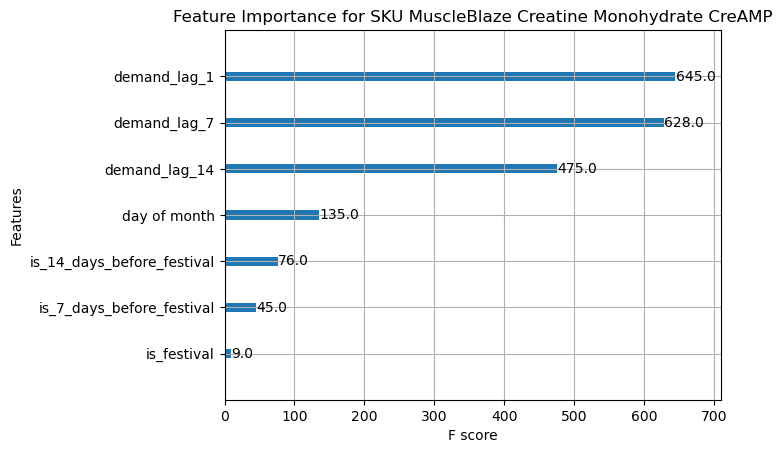

In [211]:
#plot output
plot_importance(model)
plt.title(f"Feature Importance for SKU {sku}")
plt.show()
 #Save the Results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Export to Excel
results_df.to_excel('results.xlsx', index=True)

    

In [ ]:
combined_results = pd.DataFrame()
for sku, data in results.items():
    # Create a temporary DataFrame for the SKU
    temp_df = pd.DataFrame({
        'SKU': [sku] * len(results_df['predictions']),
        'Predictions': results_df['predictions'],
        'True_Values': results_df['true_values']
    })
    # Append the temporary DataFrame to the combined results
    combined_results = pd.concat([combined_results, temp_df], ignore_index=True)

# Export the results to Excel
#combined_results.to_excel('predictions_vs_true_values.xlsx', index=False)


In [213]:
y_pred

array([58.835308, 76.62409 , 79.20824 , 59.12928 , 70.514206, 78.31806 ,
       59.611412, 53.346073, 55.61179 , 60.657677, 58.402275, 54.14434 ,
       53.58444 , 59.562347, 66.615654, 58.442574, 65.50475 , 57.29801 ,
       62.238018, 80.35474 , 54.09472 , 57.98244 , 58.000896, 58.41942 ,
       47.71481 , 45.072346, 50.952114, 50.989086, 62.89821 , 71.45498 ,
       50.22448 , 46.71288 , 55.579475, 49.056644, 48.55887 , 52.62901 ],
      dtype=float32)

In [214]:
y_test

2663    83
2668    76
2677    60
2685    70
2690    77
2694    60
2702    70
2710    73
2721    67
2724    62
2734    55
2742    55
2748    46
2753    37
2758    56
2769    69
2774    64
2784    61
2787    80
2793    62
2801    60
2808    59
2816    53
2821    43
2827    63
2833    55
2841    60
2845    66
2851    66
2858    47
2863    49
2872    56
2879    46
2884    47
2891    39
2892    18
Name: Quantity, dtype: int64